In [747]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import networkx as nx
import matplotlib.pyplot as plt
import copy
import elitism
import json

In [748]:
with open('./data.json', 'r') as file:
    data = json.load(file)
data = data[0]
data

{'stations': {'Златоуст (1)': ['0', '38', '38', '25'],
  'Кыштым (2)': ['26', '0', '7', '34'],
  'Миасс (3)': ['15', '5', '0', '27'],
  'Муслюмово (4)': ['12', '39', '1', '0']},
 'full_timetable': {'1': {'route': ['1', '3', '2'],
   'free_carriage': ['21', '21'],
   'timetable': ['02:00 - 02:38', '04:48 - 06:11', '13:35 - 13:58']},
  '2': {'route': ['2', '3'],
   'free_carriage': ['10'],
   'timetable': ['02:00 - 02:40', '04:44 - 06:09']}}}

In [749]:
stations = [list(map(int, x)) for x in data['stations'].values()]
stations

[[0, 38, 38, 25], [26, 0, 7, 34], [15, 5, 0, 27], [12, 39, 1, 0]]

In [750]:
trains = [x for x in data['full_timetable'].values()]
trains

[{'route': ['1', '3', '2'],
  'free_carriage': ['21', '21'],
  'timetable': ['02:00 - 02:38', '04:48 - 06:11', '13:35 - 13:58']},
 {'route': ['2', '3'],
  'free_carriage': ['10'],
  'timetable': ['02:00 - 02:40', '04:44 - 06:09']}]

In [751]:
for train in trains:
    train['free_carriage'].append(0)

In [752]:
timetable = ['02:44 - 03:14',
   '05:24 - 05:56',
   '09:34 - 11:00',
   '12:22 - 13:05',
   '23:43 - 00:34']

In [753]:
def convert_train_to_time_list(train_list):
    train_by_time = []
    for train_id in range(len(train_list)):
        time_list = train_list[train_id]['timetable']

        for i, time in enumerate(time_list):
            before_after = time.split('-')  # [05:24, 05:56]

            for j, rout_part in enumerate(before_after):
                free_carriage = int(train_list[train_id]['free_carriage'][i]) if j == 1 else None
                free_carriage = None if free_carriage == 0 else free_carriage
                hour, minut = [int(x) for x in rout_part.split(':')]
                new_t = hour * 100 + minut
                if i > 0 and train_by_time[-1]['time'] > new_t:
                    new_t *= 1000
                
                train_by_time.append({
                    'id': train_id, 
                    'time': new_t,
                    'st': int(train_list[train_id]['route'][i]), 
                    'free_carriage': free_carriage
                })
    return train_by_time

In [754]:
train_to_time = convert_train_to_time_list(trains)
train_to_time = sorted(train_to_time, key = lambda x: x['time'])
train_to_time

[{'id': 0, 'time': 200, 'st': 1, 'free_carriage': None},
 {'id': 1, 'time': 200, 'st': 2, 'free_carriage': None},
 {'id': 0, 'time': 238, 'st': 1, 'free_carriage': 21},
 {'id': 1, 'time': 240, 'st': 2, 'free_carriage': 10},
 {'id': 1, 'time': 444, 'st': 3, 'free_carriage': None},
 {'id': 0, 'time': 448, 'st': 3, 'free_carriage': None},
 {'id': 1, 'time': 609, 'st': 3, 'free_carriage': None},
 {'id': 0, 'time': 611, 'st': 3, 'free_carriage': 21},
 {'id': 0, 'time': 1335, 'st': 2, 'free_carriage': None},
 {'id': 0, 'time': 1358, 'st': 2, 'free_carriage': None}]

In [755]:
train_onboard_main = [[0] * len(stations) for _ in range(len(data['full_timetable']))]

In [756]:
HROM_LENGHT = sum([1 for x in train_to_time if x['free_carriage'] is not None])
VAGON_COUNT = sum([sum(i) for i in stations])
TRAIN_COUNT = 5


# константы генетического алгоритма
POPULATION_SIZE = 100   # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.2        # вероятность мутации индивидуума
MAX_GENERATIONS = 20    # максимальное количество поколений
HALL_OF_FAME_SIZE = 4
INDIVID_SIZE = 4

MAX_INDIVID = max([int(y) for x in [i['free_carriage'] for i in trains] for y in x])

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [757]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
import keras

In [758]:
TRAIN_INTERVAL = 2

first_count = len(stations) * 3 + len(stations) * TRAIN_INTERVAL + TRAIN_INTERVAL

model = keras.Sequential(
    [
        Input(shape=(1,), name='digits'),
        Dense(first_count, activation="relu"),
        # Dropout(0.2),
        Dense(first_count // 2, activation="relu"),
        # Dropout(0.2),
        Dense(len(stations), activation='softmax'),
    ]
)

In [759]:

import tensorflow as tf
optimiser = tf.keras.optimizers.RMSprop()
model.compile(optimizer=optimiser, loss='mse', metrics=['accuracy'])

model.build()
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 22)                44        
                                                                 
 dense_88 (Dense)            (None, 11)                253       
                                                                 
 dense_89 (Dense)            (None, 4)                 48        
                                                                 
Total params: 345 (1.35 KB)
Trainable params: 345 (1.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [760]:
for layer in model.layers:
    print(layer.get_weights()[0].shape)

(1, 22)
(22, 11)
(11, 4)


In [761]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [762]:
def create_individ(count):
    res = np.random.rand(count) * 2 - 1
    return creator.Individual(res)

In [763]:
toolbox = base.Toolbox()
toolbox.register("individualCreator", create_individ, model.count_params())
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [764]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
population[0]

[0.7747377852756128,
 -0.00985508221111675,
 -0.11161366883862556,
 -0.28387926505054306,
 -0.15359899305560476,
 -0.3738349639543317,
 -0.8016203955084498,
 0.652141508369094,
 -0.48027991458708974,
 -0.2767228364210219,
 0.8816078213635619,
 -0.2519189870115457,
 -0.5408362114810312,
 -0.9429746783951789,
 0.942695330266961,
 -0.15216385006458633,
 0.09174155814236795,
 0.38574442564158273,
 -0.6581934628306301,
 -0.9967123201903176,
 -0.48785245771564134,
 -0.9596887780683754,
 0.11866253798544779,
 0.2266264311773314,
 0.7937896435026084,
 -0.9288750931507159,
 0.40578229415063727,
 0.033374393562050964,
 -0.8221574763465371,
 -0.21991833129136396,
 -0.144055487084775,
 -0.4492995834731033,
 0.41830668569179186,
 0.12798087103478406,
 -0.623084357480667,
 0.3519962406933901,
 0.02423020322969527,
 0.46145575985155474,
 -0.020192028453164035,
 0.13170352790742457,
 0.19317983538543215,
 0.2748501756522581,
 -0.3840192600933834,
 -0.6005108484493351,
 0.730799644704355,
 -0.127039441

In [765]:
def get_top_train(time, st, count, leave = False):
    res = []
    for train in train_to_time:
        if train['time'] > time and train['st'] == st:
            if leave is False and train['free_carriage'] is None:
                res.extend(train_onboard[train['id']])
            if leave is True and train['free_carriage'] is not None:
                res.append(train['free_carriage'])

            if len(res) == count:
                return res
    i = len(res)
    while i <= count:
        if leave is False:
            for _ in range(len(stations)):
                res.append(0)
        else:
            res.append(0)
        i += 1
    
    return res

In [766]:
def get_train_leave(time, st, count):
    res = []
    for train in train_to_time:
        if train['time'] > time and train['st'] == st and train['free_carriage'] is not None:
            res.append(train['free_carriage'])
    
    i = len(res)
    
    for _ in range(i, count):
        res.append(0)
    return res


def get_train_comes(time, st, count, train_onboard):
    res = []
    for train in train_to_time:
        if train['time'] > time and train['st'] == st and train['free_carriage'] is not None:
            res.extend(train_onboard[train['id']])

    i = len(res)
    
    for _ in range(i, count):
        res.extend([0] * len(stations))
    return res

In [767]:
def get_total_import(new_stations):
    column_sums = []
    for j in range(len(new_stations[0])):
        column_sum = 0
        for i in range(len(new_stations)):
            column_sum += new_stations[i][j]
        column_sums.append(column_sum)
    return column_sums

In [768]:
get_total_import(stations)

[53, 82, 46, 86]

In [780]:
PENALTY_COST = 200

def shedule_cost(individual, model):
    individual = np.array(individual)
    train_onboard = copy.deepcopy(train_onboard_main)
    current_cost = 0
    penalty_count = 0
    new_stations = copy.deepcopy(stations)


    sp_ranges = []
    prev = 0
    for lay in model.get_weights():
        prev += np.prod(lay.shape)
        sp_ranges.append(prev)

    ws = np.split(individual, sp_ranges[:-1])
    model.set_weights([w.reshape(lay.shape) for w,lay in zip(ws, model.get_weights())])


    for i in range(len(train_to_time)):
        train = train_to_time[i]
        time = train['time']
        station = train['st']
        if train['free_carriage'] is None:
            for vagon_type in range(len(new_stations)):
                new_stations[station][vagon_type] += train_onboard[train['id']][vagon_type]
                train_onboard[train['id']][vagon_type] = 0
            continue

        enter = new_stations[station]
        enter += [sum(st) for st in new_stations]
        enter += get_total_import(new_stations)
        
        enter += get_train_comes(time, station, TRAIN_INTERVAL, train_onboard)
        enter += get_train_leave(time, station, TRAIN_INTERVAL)

        print(enter)

        pred = model.predict(enter)
        print(pred)
        pred = list(pred)

        max_val = max(pred)
        vagon_type = pred.index(max_val)

        # print(vagon_type, train)

        avaiable_val = max(train['free_carriage'], new_stations[station][vagon_type])

        new_stations[station][vagon_type] -= avaiable_val
        train_onboard[train['id']][vagon_type] += avaiable_val

        row_sums = []
        for row in new_stations:
            row_sum = sum(row)
            row_sums.append(row_sum)
        # print(row_sums)

        current_cost += sum(row_sums)





    # model.set_weights(individual)
    return current_cost,

In [781]:
shedule_cost(population[0], model)

[26, 0, 7, 34, 101, 67, 47, 52, 53, 82, 46, 86, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1/1 [==============================] - 0s 34ms/step
[[5.2761451e-24 5.6270909e-37 0.0000000e+00 9.9999994e-01]
 [2.5610918e-01 2.8740710e-01 3.1084269e-02 4.2539936e-01]
 [1.8427572e-04 2.1275010e-08 1.7186152e-13 9.9981570e-01]
 [2.7773534e-32 0.0000000e+00 0.0000000e+00 9.9999994e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9999994e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9999994e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9999994e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9999994e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9999994e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9999994e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9999994e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9999994e-01]
 [2.5610918e-01 2.8740710e-01 3.1084269e-02 4.2539936e-01]
 [2.5610918e-01 2.8740710e-01 3.1084269e-02 4.2539936e-01]
 [2.5610918e-01 2.8740710e-01 3.1084269e-02 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [771]:
def mate(ind1, ind2):
    ind1, ind2 = tools.cxTwoPoint(ind1, ind2)
    return ind1, ind2

def mut(individual, indpb):           
    individual = tools.mutShuffleIndexes(individual, indpb)
    return individual,

In [772]:
toolbox.register("evaluate", shedule_cost, model=model)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/HROM_LENGHT)

In [773]:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

In [774]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

In [775]:
population, logbook = elitism.eaSimpleWithElitism(population, toolbox,
                                        cxpb=P_CROSSOVER,
                                        mutpb=P_MUTATION,
                                        ngen=MAX_GENERATIONS,
                                        halloffame=hof,
                                        stats=stats,
                                        verbose=True)

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 41ms/step
gen	nevals	min 	avg    
0  	100   	6315	6405.44
1/1 [==============================] - 0s 27ms/step
1  	77    	6315	6390.02
1/1 [==============================] - 0s 28ms/step
2  	90    	6315	6383.88
1/1 [==============================] - 0s 28ms/step
3  	88    	6315	6374.64
1/1 [==============================] - 0s 29ms/step
4  	88    	6315	6372.64
1/1 [==============================] - 0s 31ms/step
5  	89    	6315	6362.64
1/1 [==============================] - 0s 30ms/step
6  	91    	6315	6351.79
1/1 [==============================] - 0s 28ms/step
7  	92    	6315	6355.41
1/1 [==============================] - 0s 28ms/step
8  	90    	6315	6355.82
1/1 [==============================] - 0s 34ms/step
9  	83    	6315	6353.66
1/1 [==============================] - 0s 29ms/step
10 	87    	6315	6354.65
1/1 [==============================] - 0s 28ms/step
11 	89    	6315	6349.95
1/1 [==============================] - 0s 29ms/step
12 	84    	6

In [776]:
maxFitnessValues, meanFitnessValues = logbook.select("min", "avg")

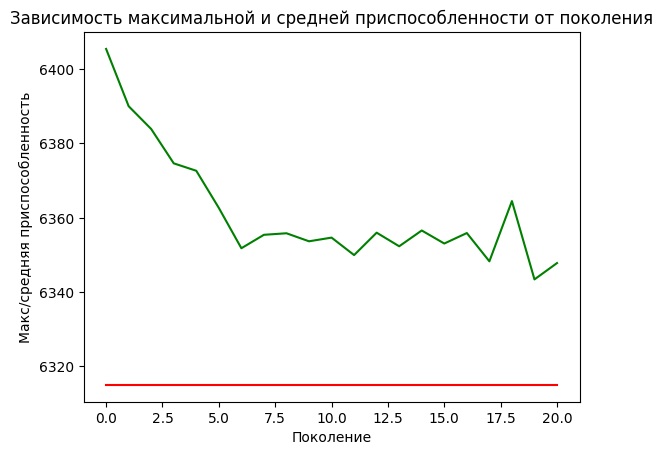

In [777]:
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Макс/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
 
plt.show()